In [98]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [99]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [100]:
dataset = '10'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [101]:
# class CFG:
#     model_type = 'LightGBM'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 1
#     repurchase_weeks = 12345
#     repurchase_num_items = 100
#     item2item_weeks = 12345
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 36
    popular_days = 7
    train_weeks = 3
    repurchase_weeks = 123456
    repurchase_num_items = 123456
    item2item_weeks = 123456
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    dynamic_feature_weeks = 8
    volume_feature_days = 7

In [102]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
        ) -> pd.DataFrame:
        day_start = 7 * week_start
        tr = transactions.query("@day_start <= day < @day_start + @CFG.popular_days")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.popular_num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.popular_num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @CFG.cooc_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'item_count': f'{strategy}_item_count'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    with timer("popular"):
        candidates_popular = create_candidates_popular('pop', transactions, target_users, week)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [103]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)
[repurchase] 0.506 s
[popular] 0.044 s
[item2item] 0.479 s
[cooccurrence] 1.161 s
[same_product_code] 0.321 s
volume: 1227784
duplicates: 1.0043157181793494
            strategy  volume     ratio
0  same_product_code  651092  0.530298
1         repurchase  331149  0.269713
2                pop  243828  0.198592
3               cooc    1715  0.001397
create candidates (week: 2)
[repurchase] 0.554 s
[popular] 0.046 s
[item2item] 0.529 s
[cooccurrence] 1.355 s
[same_product_code] 0.347 s
volume: 1332122
duplicates: 1.0051490306331103
            strategy  volume     ratio
0  same_product_code  703713  0.528265
1         repurchase  364283  0.273461
2                pop  261756  0.196496
3               cooc    2370  0.001779
create candidates (week: 3)
[repurchase] 0.569 s
[popular] 0.047 s
[item2item] 0.541 s
[cooccurrence] 1.378 s
[same_product_code] 0.368 s
volume: 1394779
duplicates: 1.0045619379953834
            strategy  volume     ratio
0  same_product_

In [104]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [105]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)
Recall: 0.12536999904516374
            strategy       y  volume    recall  hit_ratio
0                pop  1114.0  243828  0.053184   0.004569
1         repurchase   858.0  331149  0.040962   0.002591
2  same_product_code   776.0  651092  0.037048   0.001192
3               cooc    14.0    1715  0.000668   0.008163
merge labels (week: 1)
Recall: 0.11433349469700303
            strategy      y  volume    recall  hit_ratio
0                pop  953.0  261756  0.041940   0.003641
1         repurchase  931.0  364283  0.040972   0.002556
2  same_product_code  844.0  703713  0.037143   0.001199
3               cooc   19.0    2370  0.000836   0.008017
merge labels (week: 2)
Recall: 0.11641612572599931
            strategy       y  volume    recall  hit_ratio
0                pop  1091.0  271512  0.046592   0.004018
1         repurchase   889.0  375091  0.037965   0.002370
2  same_product_code   859.0  745548  0.036684   0.001152
3               cooc    22.0    2628  0.

In [106]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 1227784 -> 377636
drop trivial queries: 1332122 -> 403503
drop trivial queries: 1394779 -> 425768
drop trivial queries: 1454954 -> 451756


In [107]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()

    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)
        item_ohe_cols = [c for c in items_with_ohe.columns if c != 'item']

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)
        user_ohe_cols = [f"user_ohe_agg_{c}_mean" for c in item_ohe_cols]
        users_with_ohe = users_with_ohe[['user'] + user_ohe_cols]

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [c for c in users_with_ohe.columns if c.startswith(f"user_ohe_agg_{item_col}")]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)
[user static fetaures] 0.099 s
[item stacic features] 0.242 s
[user dynamic features (transactions)] 0.215 s
[item dynamic features (transactions)] 0.196 s
[item dynamic features (user features)] 0.239 s
[item freshness features] 0.391 s
[item volume features] 0.206 s
[user freshness features] 0.429 s
[user volume features] 0.227 s
[user-item freshness features] 1.842 s
[user-item volume features] 0.314 s
[ohe dot products] 8.887 s
[lfm features] 0.545 s
attach features (week: 1)
[user static fetaures] 0.036 s
[item stacic features] 0.071 s
[user dynamic features (transactions)] 0.093 s
[item dynamic features (transactions)] 0.084 s
[item dynamic features (user features)] 0.119 s
[item freshness features] 0.276 s
[item volume features] 0.078 s
[user freshness features] 0.289 s
[user volume features] 0.077 s
[user-item freshness features] 1.468 s
[user-item volume features] 0.101 s
[ohe dot products] 5.359 s
[lfm features] 0.144 s
attach features (week: 2)
[use

In [108]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [109]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [110]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'product_type_no_idx_ohe_score', 'product_group_name_idx_ohe_score', 'grap

In [111]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [112]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1595482	best: 0.1595482 (0)	total: 208ms	remaining: 3m 27s
1:	test: 0.1949141	best: 0.1949141 (1)	total: 406ms	remaining: 3m 22s
2:	test: 0.2018679	best: 0.2018679 (2)	total: 607ms	remaining: 3m 21s
3:	test: 0.2057439	best: 0.2057439 (3)	total: 808ms	remaining: 3m 21s
4:	test: 0.2087210	best: 0.2087210 (4)	total: 1.01s	remaining: 3m 20s
5:	test: 0.2158889	best: 0.2158889 (5)	total: 1.21s	remaining: 3m 21s
6:	test: 0.2178466	best: 0.2178466 (6)	total: 1.43s	remaining: 3m 22s
7:	test: 0.2208389	best: 0.2208389 (7)	total: 1.64s	remaining: 3m 23s
8:	test: 0.2514911	best: 0.2514911 (8)	total: 1.84s	remaining: 3m 22s
9:	test: 0.2516198	best: 0.2516198 (9)	total: 2.04s	remaining: 3m 22s
10:	test: 0.2567511	best: 0.2567511 (10)	total: 2.26s	remaining: 3m 22s
11:	test: 0.2660746	best: 0.2660746 (11)	total: 2.46s	remaining: 3m 22s
12:	test: 0.2664200	best: 0.2664200 (12)	total: 2.66s	remaining: 3m 22s
13:	test: 0.2676359	best: 0.2676359 (13)	total: 2.86s	remaining: 3m 21s
14:	test: 0.

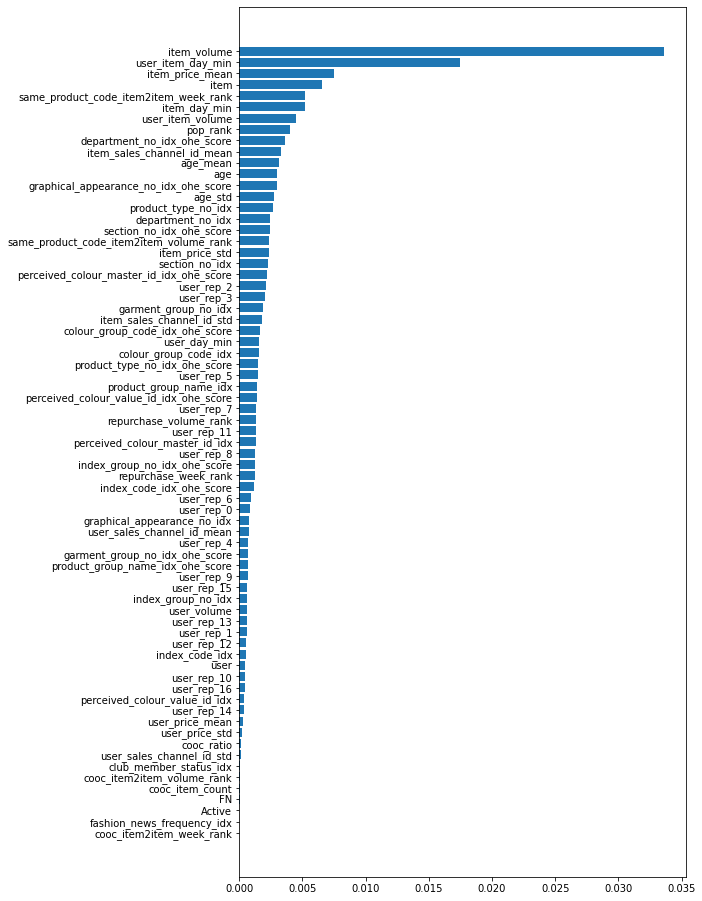

In [113]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 1000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [114]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.030082718698652505


In [115]:
assert False

AssertionError: 

submission

In [ ]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

In [ ]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

In [ ]:
all_users = users['user'].values
all_users

In [ ]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)